# Data Loading & formatting

In [ ]:
#install lib
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 21.2 MB/s 
     |████████████████████████████████| 182 kB 49.8 MB/s 
     |████████████████████████████████| 7.6 MB 65.1 MB/s 


In [ ]:
#install lib
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load libs
import json
import os
import re
import sys

import requests
import string
import numpy as np
import tqdm
import colorama

from transformers import BertTokenizer, BertForQuestionAnswering
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tokenizers import BertWordPieceTokenizer


In [ ]:
import pandas as pd
 #load dataset
df = pd.read_csv("Dataset150.csv")
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Topic     150 non-null    object
 1   Text      150 non-null    object
 2   Question  150 non-null    object
 3   Answer    150 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


None

In [ ]:
contexts = df['Text'].values.tolist()
questions = df['Question'].values.tolist()
answers = df['Answer'].values.tolist()

answer_start = []
answer_end = []

#find answer start index and end index
for i, row in df.iterrows() :
  start = row['Text'].lower().find(row['Answer'].lower())
  if (start==-1):
    print("error", i, row['Answer'])
  answer_start.append(start)
  end = start + len(row['Answer'])
  answer_end.append(end)

In [ ]:

#formatting
contexts = df['Text'].values.tolist()
questions = df['Question'].values.tolist()
answers = []

#find answer start index and end index
for i, row in df.iterrows() :
  temp_pair = {}

  temp_pair['text'] = df['Answer'][i]

  start_index = row['Text'].lower().find(row['Answer'].lower())
  temp_pair['answer_start'] = start_index

  end_index = start_index + len(row['Answer'])
  temp_pair['answer_end'] = end_index

  answers.append(temp_pair)

print(questions[0])
print(answers[0])


What is in the Universe?
{'text': 'living things, planets, stars, galaxies, dust clouds, light, and even time', 'answer_start': 85, 'answer_end': 159}


In [ ]:
#change tensor dataset
class Space_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  def __len__(self):
    return len(self.encodings.input_ids)

# using distilbert-base-uncased-distilled-squad

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

'''
https://huggingface.co/docs/transformers/model_doc/distilbert

DistilBertTokenizerFast is identical to BertTokenizerFast 
and runs end-to-end tokenization: punctuation splitting and wordpiece.
'''

'\nhttps://huggingface.co/docs/transformers/model_doc/distilbert\n\nDistilBertTokenizerFast is identical to BertTokenizerFast \nand runs end-to-end tokenization: punctuation splitting and wordpiece.\n'

In [ ]:
from transformers import BertTokenizerFast
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#tokenizer context and questions 
train_encodings = distilbert_tokenizer(contexts, questions, truncation=True, padding=True)
print(train_encodings.keys())
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
We have 150 context-question pairs


In [ ]:
train_encodings = auto_tokenizer(contexts, questions, truncation=True, padding=True)
print(train_encodings.keys())
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

dict_keys(['input_ids', 'attention_mask'])
We have 150 context-question pairs


In [ ]:
# adding the answers in the training set for fine tuning
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answer_start[i]))
    end_positions.append(encodings.char_to_token(i, answer_end[i] - 1))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = auto_tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = auto_tokenizer.model_max_length
  
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, answers)

In [ ]:
train_dataset = Space_Dataset(train_encodings)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
#model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')
auto_model = AutoModelForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Working on cuda


In [ ]:
model = auto_model

In [ ]:
N_EPOCHS = 5
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

'''
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
'''

optimizer = torch.optim.Adam(lr=1e-5, betas=(0.9, 0.98), eps=1e-9, params=optimizer_grouped_parameters)

model.to(device)
model.train()

for epoch in range(N_EPOCHS):
  #loop = tqdm(train_loader, leave=True)
  print('epoch ', epoch)
  tr_loss = 0
  nb_tr_steps = 0
  for step, batch in enumerate(train_loader):
    print('step', step)
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_steps += 1

  print(f"\nTraining loss={tr_loss / nb_tr_steps:.4f}")
  torch.save(model.state_dict(), "./weights_" + str(epoch) + ".pth")

torch.save(model, '/content/drive/MyDrive/BERT-SQuAD/auto_distilbert.pth')

epoch  0
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=4.5244
epoch  1
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=3.4475
epoch  2
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=2.7882
epoch  3
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
st

# using bert-large-uncased-whole-word-masking-finetuned-squad

In [ ]:
#for understanding dataset characters
print('number of topics', len(df['Topic'].unique()), df['Topic'].unique())
tokens_questions_texts = []

for index, row in df.iterrows():
  input_ids = SPUAD_tokenizer.encode(row['Question'], row['Text'])
  tokens = SPUAD_tokenizer.convert_ids_to_tokens(input_ids)
  for token, id in zip(tokens, input_ids):
    #print('{:8}{:8,}'.format(token,id))
    tokens_questions_texts.append(token)

#understanding lengths
print('len - voca', len(tokens_questions_texts))
print('len - unique voca', len(set(tokens_questions_texts)))

question_n_tokens = []
text_n_tokens = []

for index, row in df.iterrows():
  input_ids = SPUAD_tokenizer.encode(row['Question'], row['Text'])
  sep_idx = input_ids.index(SPUAD_tokenizer.sep_token_id)
  question_n_tokens.append(sep_idx+1)
  text_n_tokens.append(len(input_ids) - (sep_idx+1))

#understanding average tokens
print('mean(question_n_tokens)', round(sum(question_n_tokens) / len(question_n_tokens)))
print('mean(text_n_tokens)', round(sum(text_n_tokens) / len(text_n_tokens)))

number of topics 19 ['The Universe' 'The Big Bang' 'Our nearest star' 'The Sun'
 'Birth of the Moon' 'Stars' 'Stars birth' 'Dwarfs and supergiants'
 'Galaxies' 'What Is Gravity?' 'satellite' 'Death of the dinosaurs'
 'Meteorites ' 'Mars' 'Space Exploration' 'Earth'
 'The Threat of Melting Ice' 'climate change' 'solar system']
len - voca 44607
len - unique voca 1265
mean(question_n_tokens) 10
mean(text_n_tokens) 287


In [ ]:
#load tokenizer
from transformers import BertTokenizerFast
#model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
SPUAD_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

In [ ]:
train_encodings = SPUAD_tokenizer(contexts, questions, truncation=True, padding=True)
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
#make sure whole dataset is loaded
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 150 context-question pairs


In [ ]:
# adding the answers in the training set for fine tuning
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answer_start[i]))
    end_positions.append(encodings.char_to_token(i, answer_end[i] - 1))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = SPUAD_tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = SPUAD_tokenizer.model_max_length
  
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, answers)

In [ ]:
print(train_encodings[0])

Encoding(num_tokens=435, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
print(train_encodings[0].ids)
print(train_encodings[0].type_ids)
print(train_encodings[0].offsets)
print(train_encodings[0].attention_mask)
print(train_encodings[0].special_tokens_mask)
print(train_encodings[0].overflowing)

[101, 1996, 5304, 2003, 2673, 2057, 2064, 3543, 1010, 2514, 1010, 3168, 1010, 5468, 2030, 11487, 1012, 2009, 2950, 2542, 2477, 1010, 11358, 1010, 3340, 1010, 21706, 1010, 6497, 8044, 1010, 2422, 1010, 1998, 2130, 2051, 1012, 2077, 1996, 4182, 1997, 1996, 5304, 1010, 2051, 1010, 2686, 1998, 3043, 2106, 2025, 4839, 1012, 1996, 5304, 3397, 25501, 1997, 21706, 1010, 2169, 4820, 8817, 2030, 25501, 1997, 3340, 1012, 1996, 2686, 2090, 1996, 3340, 1998, 21706, 2003, 4321, 4064, 1012, 2174, 1010, 2130, 3182, 2521, 2013, 3340, 1998, 11358, 5383, 7932, 9309, 1997, 6497, 2030, 1037, 2261, 9732, 13353, 2566, 11919, 9358, 19198, 1012, 2686, 2003, 2036, 3561, 2007, 8249, 1006, 1041, 1012, 1043, 1012, 2422, 1998, 3684, 1007, 1010, 8060, 4249, 1998, 2152, 2943, 9309, 1006, 1041, 1012, 1043, 1012, 14448, 9938, 1007, 1012, 1996, 5304, 2003, 11757, 4121, 1012, 2009, 2052, 2202, 1037, 2715, 6892, 4959, 2062, 2084, 1037, 2454, 2086, 2000, 3362, 1996, 7205, 2732, 2000, 1996, 3103, 1012, 8932, 2012, 1996, 317

In [ ]:
class Space_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  def __len__(self):
    return len(self.encodings.input_ids)

In [ ]:
train_dataset = Space_Dataset(train_encodings)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)


In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cpu


In [ ]:
N_EPOCHS = 5
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

'''
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
'''

optimizer = torch.optim.Adam(lr=1e-5, betas=(0.9, 0.98), eps=1e-9, params=optimizer_grouped_parameters)

model.to(device)
model.train()

for epoch in range(N_EPOCHS):
  #loop = tqdm(train_loader, leave=True)
  print('epoch ', epoch)
  tr_loss = 0
  nb_tr_steps = 0
  for step, batch in enumerate(train_loader):
    print('step', step)
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_steps += 1

  print(f"\nTraining loss={tr_loss / nb_tr_steps:.4f}")
  torch.save(model.state_dict(), "./weights_" + str(epoch) + ".pth")

torch.save(model, '/content/drive/MyDrive/BERT-SQuAD/model150.pth')

epoch  0
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=2.3990
epoch  1
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=1.1283
epoch  2
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29

Training loss=0.6045
epoch  3
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
st

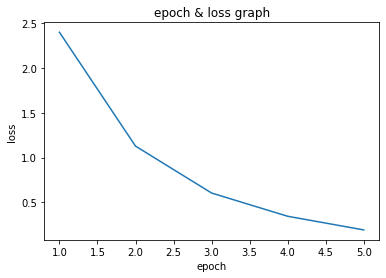

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

# x axis values
x = [1,2,3,4,5]
# corresponding y axis values
y = [2.3990, 1.1283, 0.6045, 0.3451, 0.1929


# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('loss')

# giving a title to my graph
plt.title('epoch & loss graph')

# function to show the plot
plt.show()


trained with 90 samples

In [ ]:
N_EPOCHS = 5
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.Adam(lr=1e-5, betas=(0.9, 0.98), eps=1e-9, params=optimizer_grouped_parameters)

model.to(device)
model.train()

for epoch in range(N_EPOCHS):
  loop = tqdm(train_loader, leave=True)
  tr_loss = 0
  nb_tr_steps = 0
  for step, batch in enumerate(train_loader):
    print('step', step)
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_steps += 1

  print(f"\nTraining loss={tr_loss / nb_tr_steps:.4f}")
  torch.save(model.state_dict(), "./weights_" + str(epoch) + ".pth")

  0%|          | 0/12 [00:00<?, ?it/s]

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11

Training loss=2.8452



  0%|          | 0/12 [10:21<?, ?it/s]


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11

Training loss=1.4001


  0%|          | 0/12 [10:14<?, ?it/s]


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11

Training loss=0.8670



  0%|          | 0/12 [10:09<?, ?it/s]


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11

Training loss=0.5048


  0%|          | 0/12 [10:10<?, ?it/s]


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11

Training loss=0.3766


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model, '/content/drive/MyDrive/BERT-SQuAD/model.pth')

In [ ]:
import pandas as pd
 
df = pd.read_csv("results.csv")
df.head()

,Unnamed: 0,before_predicted_answers,after_predicted_answers,Answer
0,0,We cannot see edge,We cannot see edge,we cannot see the edge
1,1,Radiation e g light and heat magnetic fields a...,Radiation e g light and heat magnetic fields a...,Space is also filled with radiation (e.g. ligh...
2,2,300 000 km per second,300 000 km per second,"300,000 km per second"
3,3,East,Towards east,Earth is spinning towards the east
4,4,8 minutes,It takes about 8 minutes,it takes about 8 minutes for sunlight to reach us
